# Ablation studies

In this notebook we give the scripts for various ablation studies resented in out paper:
- **Weights**<br>
    Verifying the role of the pair of constant shared weights used for `epsilon` computation.<br>
- **Batch size**<br>
    Investigating the effect of the batch size.<br>
- **Synthetic data**<br>
    Changing the input data to verify dependency of the method on the data.
- **Initializations**<br>
    Changing initialization scheme.

In [1]:
import os
import json
import time
import itertools

import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
from tqdm import trange
from scipy import stats
from thop import profile
from dotmap import DotMap
from statistics import mean
import matplotlib.pyplot as plt
from prettytable import PrettyTable

import torch.nn as nn
import torch

import nasspace
from datasets import data
from epsinas_utils import prepare_seed, compute_stats, plot_results, search_weights, compute_epsinas, epsinas_main, bs_ablation_plots

In [2]:
# Select the dataset. Choose among: 'cifar10', 'cifar100', 'ImageNet16-120'
dataset = 'cifar10'

if dataset=='ImageNet16-120':
    data_loc = './datasets/ImageNet16'
else:
    data_loc = './datasets'

In [3]:
save_loc = './results'
batch_size = 256
repeat = 1
GPU = '1'
augtype = 'none'
trainval = False

In [4]:
# Arguments required for NAS-Bench-201 search space initialisation
args = DotMap()
args.nasspace = 'nasbench201'
args.dataset = dataset
args.api_loc = './api/NAS-Bench-201-v1_1-096897.pth'
args.trainval = trainval

savedataset = dataset 
dataset = 'fake' if 'fake' in savedataset else savedataset
savedataset = savedataset.replace('fake', '')
if savedataset == 'cifar10':
    savedataset = savedataset + '-valid'

In [5]:
if 'valid' in savedataset:
    savedataset = savedataset.replace('-valid', '')

if dataset == 'cifar10':
    acc_type = 'ori-test'
else:
    acc_type = 'x-test'

args.acc_type = acc_type

In [6]:
# Define the device
os.environ['CUDA_VISIBLE_DEVICES'] = GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Randomly select n_samples architectures
prepare_seed(21)

In [7]:
# Load the search space (it takes some time)
searchspace = nasspace.get_search_space(args)

./api/NAS-Bench-201-v1_1-096897.pth


In [8]:
# Load the data 
train_loader = data.get_data(dataset, data_loc, trainval, batch_size, augtype, repeat, args)
# os.makedirs(args.save_loc, exist_ok=True)

# Pick up a batch
data_iterator = iter(train_loader)
x, _= next(data_iterator)
x = x.to(device)

Files already downloaded and verified
Files already downloaded and verified


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.




## Weights ablations

In this ablation study we verify how much does the performance of epsilon metric change depending on the chosen weights.

In [10]:
weight_range = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
add_header = True
for weights in itertools.product(weight_range, weight_range):
    weight_l = weights[0]
    weight_h = weights[1]
    
    if weight_h>weight_l:
        save_dir = f'../epsinas-release-data/NAS-Bench-201/ablation/weights/{dataset.upper()}/weights_{weight_l}_{weight_h}/'
        os.makedirs(save_dir, exist_ok=True)
        
        if os.path.exists(save_dir+'data'):
            # Load precomputed results
            data_file = open(save_dir+'data','rb')
            input_data = pkl.load(data_file)
            score = input_data["score"]
            accs = input_data["accs"]
            nparams = input_data["nparams"]
        else:
            save_dic = epsinas_main(data=x,
                                    space_name=args.nasspace,
                                    searchspace=searchspace, 
                                    n_archs=5000,
                                    weights=weights,
                                    device=device,
                                    args=args)
            pkl.dump(save_dic, open(save_dir + "data", "wb"))
            
        if add_header:
            # Create output table
            headers = ["Weights", "Archs", "Spearman (global)", "Spearman (top-10%)", "Kendall (global)", "Kendall (top-10%)", "Top-10%/top-10%", "Top-64/top-5%"]
            table = PrettyTable(headers)
            add_header = False
        stats, remain = compute_stats(score, accs)
        stats_print = ["[{}, {}]".format(weight_l, weight_h), remain] + stats
        table.add_row(stats_print)

In [12]:
table

Weights,Archs,Spearman (global),Spearman (top-10%),Kendall (global),Kendall (top-10%),Top-10%/top-10%,Top-64/top-5%
"[1e-07, 1e-06]",2957,0.33,-0.20,0.22,-0.13,4.76,1.00
"[1e-07, 1e-05]",2957,0.39,-0.06,0.29,-0.04,9.15,2.00
"[1e-07, 0.0001]",2957,0.47,-0.01,0.32,0.00,9.12,2.00
"[1e-07, 0.001]",2957,0.62,0.06,0.43,0.05,18.92,3.00
"[1e-07, 0.01]",2957,0.83,0.69,0.64,0.49,68.40,56.00
"[1e-07, 0.1]",2957,0.84,0.64,0.65,0.46,68.03,56.00
"[1e-07, 1]",2957,0.87,0.59,0.70,0.43,65.88,45.00
"[1e-06, 1e-05]",2957,0.41,-0.06,0.30,-0.04,9.15,2.00
"[1e-06, 0.0001]",2957,0.47,-0.01,0.32,0.00,9.12,2.00
"[1e-06, 0.001]",2957,0.62,0.06,0.43,0.05,18.92,3.00


## Batch size

We test the effect of the batch size used during `epsilon` metric computation.

In [13]:
batch_size_range = [8, 16, 32, 64, 128, 256, 512, 1024]

batch_all_spearman_all = []
batch_top10_spearman_all = []
batch_all_kendall_all = []
batch_top10_kendall_all = []
batch_top10top10_all = []
batch_top64top5_all = []

for batch_size in batch_size_range:
    batch_all_spearman = []
    batch_top10_spearman = []
    batch_all_kendall = []
    batch_top10_kendall = []
    batch_top10top10 = []
    batch_top64top5 = []
    
    for it in range(10):
        save_dir = f'../epsinas-release-data/NAS-Bench-201/ablation/batch_size/{dataset.upper()}/batch_size_{batch_size}/'
        os.makedirs(save_dir, exist_ok=True)

        if os.path.exists(save_dir+'data_' + str(it)):
            # Load precomputed results
            data_file = open(save_dir + 'data_' + str(it),'rb')
            input_data = pkl.load(data_file)
            score = input_data["score"]
            accs = input_data["accs"]
            nparams = input_data["nparams"]
        else:
            # Load the data batch
            if it==0:
                print("Loading the data for a custom batch split...")
                train_loader = data.get_data(dataset, data_loc, trainval, batch_size, augtype, repeat, args)
            print("Data loaded!")
            data_iterator = iter(train_loader)
            x, _= next(data_iterator)
            x = x.to(device)

            save_dic = epsilon_main(data=x,
                                    space_name=args.nasspace,
                                    searchspace=searchspace, 
                                    n_archs=5000,
                                    weights=weights,
                                    device=device,
                                    args=args)
            pkl.dump(save_dic, open(save_dir + "data_" + str(it), "wb"))

        stats, remain = compute_stats(score, accs, raw=True)
        batch_all_spearman.append(stats[0])
        batch_top10_spearman.append(stats[1])
        batch_all_kendall.append(stats[2])
        batch_top10_kendall.append(stats[3])
        batch_top10top10.append(stats[4])
        batch_top64top5.append(stats[5])

    batch_all_spearman_all.append(batch_all_spearman)
    batch_top10_spearman_all.append(batch_top10_spearman)
    batch_all_kendall_all.append(batch_all_kendall)
    batch_top10_kendall_all.append(batch_top10_kendall)
    batch_top10top10_all.append(batch_top10top10)
    batch_top64top5_all.append(batch_top64top5)

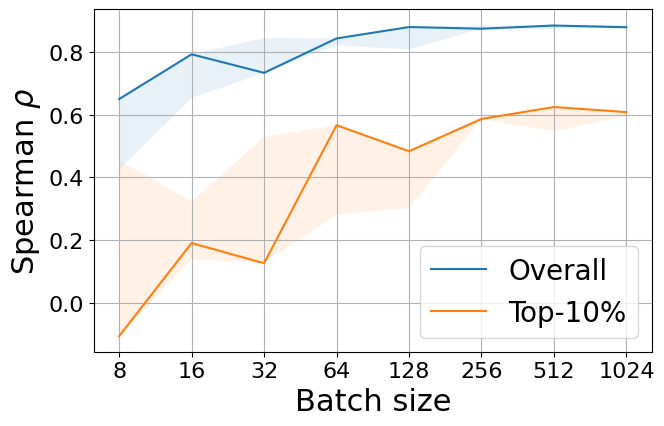

In [15]:
filename = f"../epsinas-release-data/NAS-Bench-201/ablation/batch_size/{dataset.upper()}/BatchSize_Spearman_201_{dataset.upper()}.pdf"
if dataset == 'cifar10':
    title = 'CIFAR-10'
 # 'CIFAR-10', 'CIFAR-100', 'ImageNet16-120'
bs_ablation_plots([(batch_all_spearman_all,'Overall'), (batch_top10_spearman_all,'Top-10%')], 'rho', filename, dataset)

/home/gracheva/Work/NAS/epsinas/NAS-Bench-201/epsinas_utils.py:316: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','8','16','32','64','128','256','512','1024'])


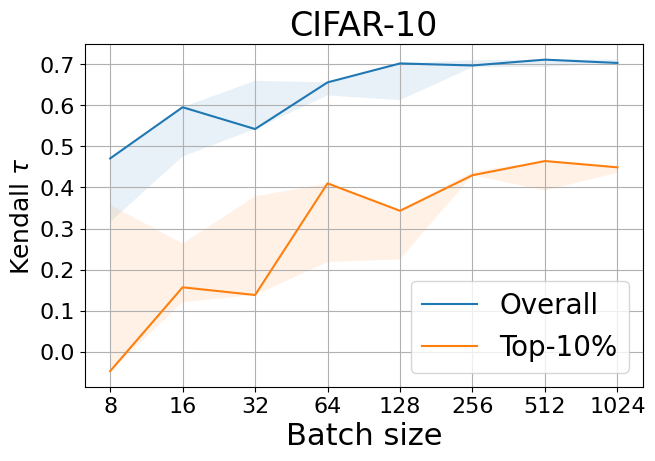

In [16]:
filename = f"../epsinas-release-data/NAS-Bench-201/ablation/batch_size/{dataset.upper()}/BatchSize_Kendall_201_{dataset.upper()}.pdf"
bs_ablation_plots([(batch_all_kendall_all,'Overall'), (batch_top10_kendall_all,'Top-10%')], 'tau', filename, dataset)

## Synthetic data

In [17]:
# Grey scale
def grey_scale(bs):
    x = np.zeros((bs, 3, 32, 32))
    for i in range(bs):
        x[i,:,:,:]=1/bs*i
    x = torch.from_numpy(x)
    return x.to(device).float()

# Random normal
def random_normal(bs):
    x = np.random.normal(0, 1, size=(bs, 3, 32, 32))
    x = torch.from_numpy(x)
    return x.to(device).float()

# Ramdom uniform
def random_uniform_pos(bs):
    x = np.random.uniform(0, 1, size=(bs, 3, 32, 32))
    x = torch.from_numpy(x)
    return x.to(device).float()

# Ramdom uniform
def random_uniform(bs):
    x = np.random.uniform(-1, 1, size=(bs, 3, 32, 32))
    x = torch.from_numpy(x)
    return x.to(device).float()

def real_batch(args):
    # Load the data 
    train_loader = data.get_data(dataset, data_loc, trainval, batch_size, augtype, repeat, args)
    # Pick up a batch
    data_iterator = iter(train_loader)
    x, _= next(data_iterator)
    return x.to(device)

Files already downloaded and verified
Files already downloaded and verified
Correlation plot for real_batch input data


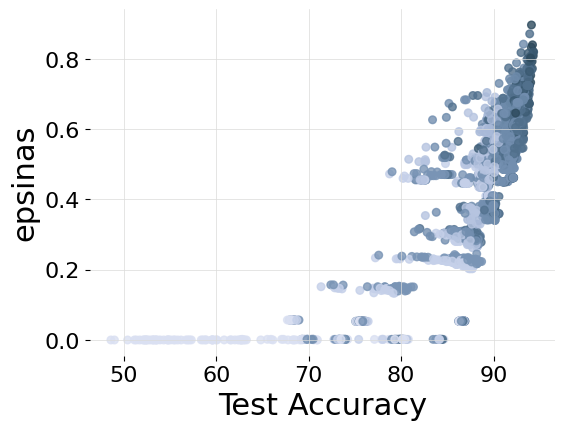

Correlation plot for grey_scale input data


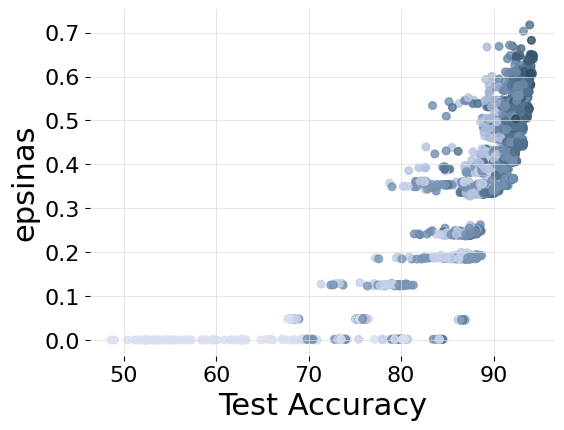

Correlation plot for random_normal input data


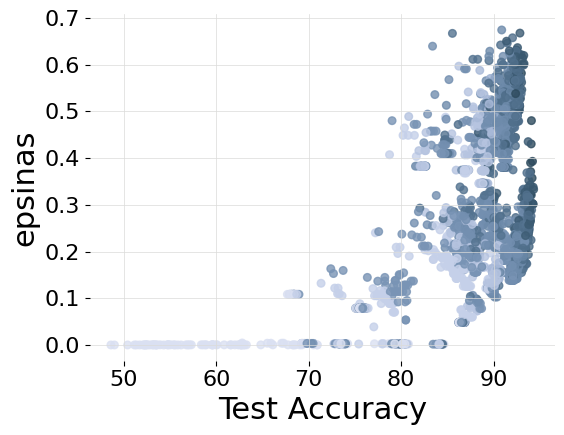

Correlation plot for random_uniform input data


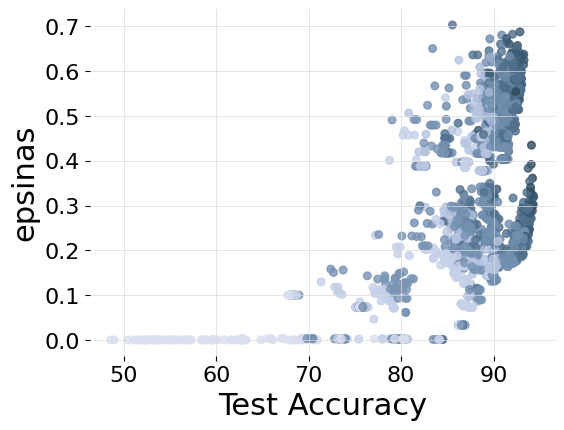

Correlation plot for random_uniform_pos input data


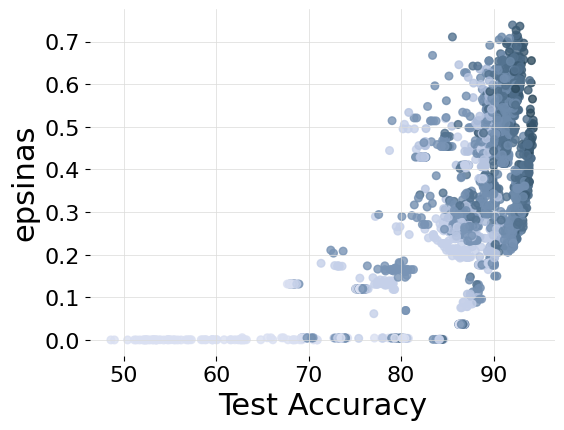

In [18]:
prepare_seed(21)
weights = [1e-7, 1]

input_names=['real_batch',
             'grey_scale',
             'random_normal',
             'random_uniform',
             'random_uniform_pos']
it=0
for input_name in input_names:
    save_dir = f'../epsinas-release-data/NAS-Bench-201/ablation/synthetic_input/{dataset.upper()}/{input_name}/'
    os.makedirs(save_dir, exist_ok=True)
    
    if input_name=='real_batch':
        x = real_batch(args)
    elif input_name=='grey_scale':
        x = grey_scale(batch_size)
    elif input_name=='random_normal':
        x = random_normal(batch_size)
    elif input_name=='random_uniform':
        x = random_uniform(batch_size)
    elif input_name=='random_uniform_pos':
        x = random_uniform_pos(batch_size)

    if os.path.exists(save_dir+'data'):
        # Load precomputed results
        data_file = open(save_dir+'data','rb')
        input_data = pkl.load(data_file)
        score = input_data["score"]
        accs = input_data["accs"]
        nparams = input_data["nparams"]
    else:
        save_dic = epsinas_main(data=x,
                                space_name=args.nasspace,
                                searchspace=searchspace, 
                                n_archs=5000,
                                weights=weights,
                                device=device,
                                args=args)
        pkl.dump(save_dic, open(save_dir + "data", "wb"))
        score = save_dic['score']
        accs = save_dic['accs']

    if it==0:
        # Make the table
        headers = ["Input", "Archs", "Spearman (global)", "Spearman (top-10%)", "Kendall (global)", "Kendall (top-10%)", "Top-10%/top-10%", "Top-64/top-5%"]
        table = PrettyTable(headers)
    
    stats, remain = compute_stats(score, accs)
    stats_print = [input_name, remain] + stats  
    table.add_row(stats_print)
    it+=1
    
    print(f"Correlation plot for {input_name} input data")

#     plot_results(score=score,
#                  accs=accs,
#                  nparams=nparams,
#                  top10=False,
#                  log_scale=False,
#                  save_dir=save_dir,
#                  save_name="epsinas_{}".format(input_name))

In [19]:
table

Input,Archs,Spearman (global),Spearman (top-10%),Kendall (global),Kendall (top-10%),Top-10%/top-10%,Top-64/top-5%
real_batch,2957,0.87,0.59,0.70,0.43,65.88,45.00
grey_scale,2957,0.87,0.44,0.68,0.31,59.46,34.00
random_normal,2957,0.54,0.15,0.38,0.14,14.97,3.00
random_uniform,2957,0.56,0.17,0.40,0.16,14.19,3.00
random_uniform_pos,2957,0.61,0.17,0.43,0.16,16.22,4.00


### Initialisation algorithm

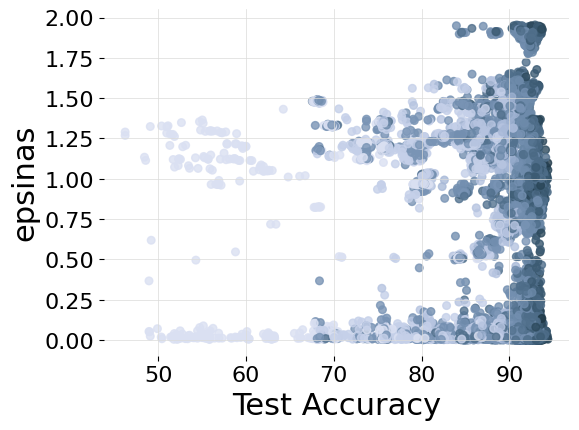

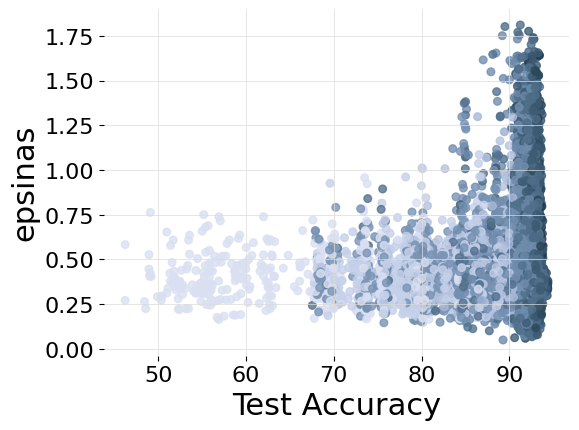

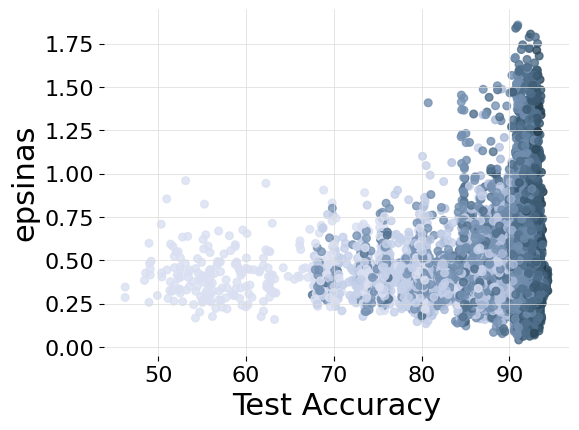

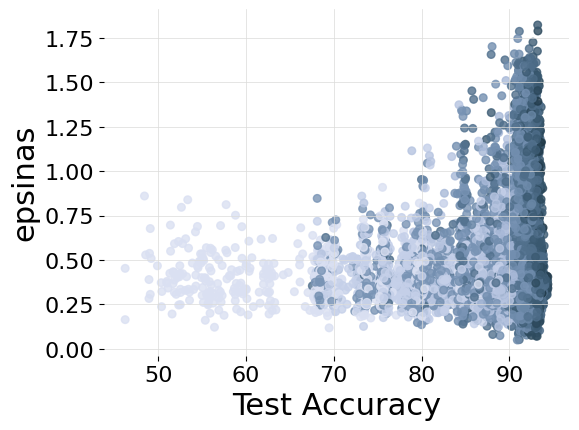

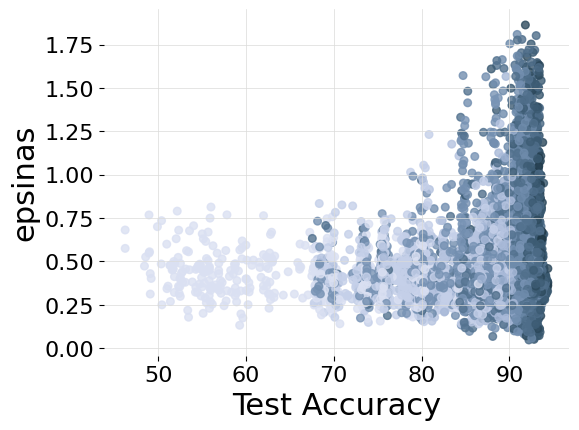

In [24]:
import torch.nn as nn

prepare_seed(21)
weights = [1e-7, 1]
n_archs = len(searchspace)

init_names=['uniform',
            'normal',
            'kaiming_uniform',
            'kaiming_normal',
            'orthogonal']

it=0

for init_name in init_names:
    save_dir = f'../epsinas-release-data/NAS-Bench-201/ablation/initialization/{dataset.upper()}/{init_name}/'
    os.makedirs(save_dir, exist_ok=True)
    
    if os.path.exists(save_dir+'data'):
        # Load precomputed results
        data_file = open(save_dir+'data','rb')
        input_data = pkl.load(data_file)
        score = input_data["score"]
        accs = input_data["accs"]
        nparams = input_data["nparams"]

    else:
        accs = []
        nparams = []
        score = []
        for i in trange(n_archs):
            uid = searchspace[i]
            network = searchspace.get_network(uid)
            network = network.to(device)
            preds = []
            for weight in weights:
                torch.cuda.empty_cache()
                # Implementing different initialization schemes
                if init_name=='uniform':
                    def initialize_resnet(m):
                        if isinstance(m, nn.Conv2d):
                            nn.init.uniform_(m.weight)
                            if m.bias is not None:
                                nn.init.constant_(m.bias, 0)
                        elif isinstance(m, nn.BatchNorm2d):
                            nn.init.constant_(m.weight, 1)
                            if m.bias is not None:
                                nn.init.constant_(m.bias, 0)
                        elif isinstance(m, nn.Linear):
                            nn.init.normal_(m.weight, 0, 0.01)
                            nn.init.constant_(m.bias, 0)

                elif init_name=='normal':
                    def initialize_resnet(m):
                        if isinstance(m, nn.Conv2d):
                            nn.init.normal_(m.weight)
                            if m.bias is not None:
                                nn.init.constant_(m.bias, 0)
                        elif isinstance(m, nn.BatchNorm2d):
                            nn.init.constant_(m.weight, 1)
                            if m.bias is not None:
                                nn.init.constant_(m.bias, 0)
                        elif isinstance(m, nn.Linear):
                            nn.init.normal_(m.weight, 0, 0.01)
                            nn.init.constant_(m.bias, 0)

                elif init_name=='kaiming_uniform':
                    def initialize_resnet(m):
                        if isinstance(m, nn.Conv2d):
                            nn.init.kaiming_uniform_(m.weight)
                            if m.bias is not None:
                                nn.init.constant_(m.bias, 0)
                        elif isinstance(m, nn.BatchNorm2d):
                            nn.init.constant_(m.weight, 1)
                            if m.bias is not None:
                                nn.init.constant_(m.bias, 0)
                        elif isinstance(m, nn.Linear):
                            nn.init.normal_(m.weight, 0, 0.01)
                            nn.init.constant_(m.bias, 0)

                elif init_name=='kaiming_normal':
                    def initialize_resnet(m):
                        if isinstance(m, nn.Conv2d):
                            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                            if m.bias is not None:
                                nn.init.constant_(m.bias, 0)
                        elif isinstance(m, nn.BatchNorm2d):
                            nn.init.constant_(m.weight, 1)
                            if m.bias is not None:
                                nn.init.constant_(m.bias, 0)
                        elif isinstance(m, nn.Linear):
                            nn.init.normal_(m.weight, 0, 0.01)
                            nn.init.constant_(m.bias, 0)

                elif init_name=='orthogonal':
                    def initialize_resnet(m):
                        if isinstance(m, nn.Conv2d):
                            nn.init.orthogonal_(m.weight)
                            if m.bias is not None:
                                nn.init.constant_(m.bias, 0)
                        elif isinstance(m, nn.BatchNorm2d):
                            nn.init.constant_(m.weight, 1)
                            if m.bias is not None:
                                nn.init.constant_(m.bias, 0)
                        elif isinstance(m, nn.Linear):
                            nn.init.normal_(m.weight, 0, 0.01)
                            nn.init.constant_(m.bias, 0)


                network.apply(initialize_resnet)
                with torch.no_grad():
                    y_pred, _ = network(x)
                pred = y_pred.cpu().detach().numpy().flatten()
                pred_min = np.nanmin(pred)
                pred_max = np.nanmax(pred)
                pred_norm = (pred - pred_min)/(pred_max - pred_min)
                preds.append(pred_norm)

            # Compute the score
            preds = np.array(preds)
            preds[np.where(preds==0)] = np.nan
            mae = np.nanmean(np.abs(preds[0,:]-preds[1,:]))
            mean = np.nanmean(preds)

            score.append(mae/mean)
            nparams.append(sum(p.numel() for p in network.parameters()))
            accs.append(searchspace.get_final_accuracy(uid, acc_type, trainval))

        save_dic = {}
        save_dic["accs"] = accs
        save_dic["score"] = score
        save_dic["nparams"] = nparams

        pkl.dump(save_dic, open(save_dir + "data", "wb"))

    if it==0:
        # Make the table
        headers = ["Initialization", "Spearman (global)", "Spearman (top-10%)", "Kendall (global)", "Kendall (top-10%)", "Top-10%/top-10%", "Top-64/top-5%"]
        table = PrettyTable(headers)
    
    stats, _ = compute_stats(score, accs)
    stats_print = [init_name] + stats
    table.add_row(stats_print)
    it+=1

#     plot_results(score=score,
#                  accs=accs,
#                  nparams=nparams,
#                  top10=False,
#                  log_scale=False,
#                  save_dir=save_dir,
#                  save_name="epsinas_{}".format(init_name))

In [23]:
table

Initialization,Spearman (global),Spearman (top-10%),Kendall (global),Kendall (top-10%),Top-10%/top-10%,Top-64/top-5%
uniform,-0.02,-0.01,-0.01,-0.00,7.13,13.00
normal,0.08,-0.20,0.05,-0.13,15.83,4.00
kaiming_uniform,0.07,-0.17,0.05,-0.12,13.60,2.00
kaiming_normal,0.07,-0.13,0.05,-0.09,12.49,1.00
orthogonal,0.07,-0.16,0.05,-0.10,11.71,6.00
